#Постановка задачи
В рамках анализа клиентского опроса и технических метрик связи от компании «Мегафон» мы хотим понять, какие технические параметры оказывают влияние на восприятие качества связи пользователями (оценка Q1).

Цель анализа — выявить значимые факторы, которые связаны с неудовлетворённостью пользователей, чтобы определить приоритетные направления для технических улучшений.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
plt.style.use('dark_background')

megafon.csv содержит следующие значения:

     user_id — идентификатор абонента;
     Q1 — ответ на первый вопрос;
     Q2 — ответ на второй вопрос;
     Total Traffic(MB) — объем трафика передачи данных 1 ;
     Downlink Throughput(Kbps) — средняя скорость «к абоненту» 2 ;
     Uplink Throughput(Kbps)— средняя скорость «от абонента» 3 ;
     Downlink TCP Retransmission Rate(%) — частота переотправок пакетов «к абоненту» 4 ;
     Video Streaming Download Throughput(Kbps) — скорость загрузки потокового видео 5 ;
     Video Streaming xKB Start Delay(ms) — задержка старта воспроизведения видео 6 ;
     Web Page Download Throughput(Kbps) — скорость загрузки web-страниц через браузер 7 ;
     Web Average TCP RTT(ms) — пинг при просмотре web-страниц8 .

1 — Насколько активно абонент использует мобильный интернет.
2 — Считается по всему трафику передачи данных.
3 — Считается по всему трафику передачи данных.
4 — Чем выше, тем хуже. Если в канале возникает ошибка, пакет переотправляется. Снижается полезная скорость.
5 — Чем выше, тем лучше — меньше прерываний и лучше качество картинки.
6 — Сколько времени пройдёт между нажатием на кнопку Play и началом воспроизведения видео. Чем меньше это время, тем быстрее начинается воспроизведение.
7 — Чем выше, тем лучше.
8 — Чем меньше, тем лучше — быстрее загружаются web-страницы.

Первый технический показатель представлен как сумма за период в одну неделю перед участием в опросе. Остальные технические показатели отображают среднее значение по данному признаку за период в одну неделю перед участием в опросе.

In [ ]:
uploaded = files.upload()

Saving megafon.csv to megafon.csv


In [ ]:
df = pd.read_csv('megafon.csv')

In [ ]:
df.head()

,user_id,Q1,Q2,Total Traffic(MB),Downlink Throughput(Kbps),Uplink Throughput(Kbps),Downlink TCP Retransmission Rate(%),Video Streaming Download Throughput(Kbps),Video Streaming xKB Start Delay(ms),Web Page Download Throughput(Kbps),Web Average TCP RTT(ms)
0,1,5,NaN,775.48846,360.13,86.56,3.93,1859.15,2309,1007.82,83
1,2,5,4,861.96324,3023.54,411.18,1.27,667.47,2080,255.36,425
2,3,1,4,261.11860,790.96,34.20,1.79,1079.60,6367,535.85,485
3,4,8,3,179.18564,2590.97,325.88,0.80,7053.81,3218,1221.02,51
4,5,2,"2, 3, 4",351.99208,731.61,223.54,1.15,4550.38,1767,2336.56,68


#Проверка и предобработка данных

<Axes: >

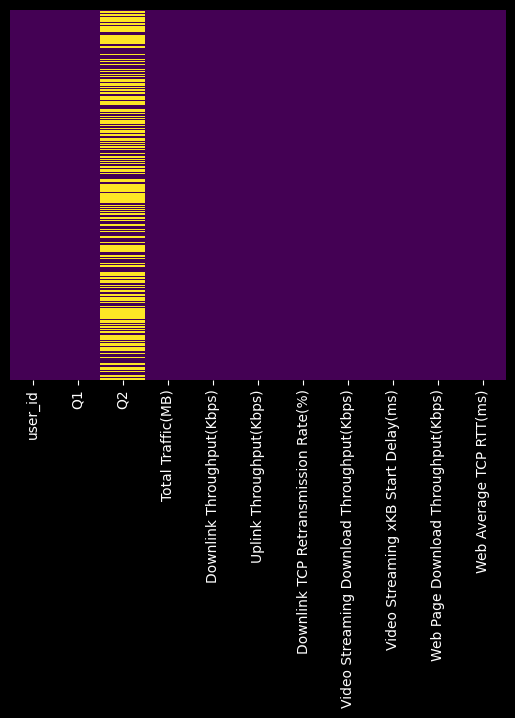

In [ ]:
#Проверяем данные на наличие нулевых значений.
sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)

Нулевые значения встречаются только в Q2 - это нормально, не всем пользователям задавали второй вопрос.

In [ ]:
#Проверяем валидность значений
df['Q1'].unique(), df['Q2'].unique()

(array(['5', '1', '8', '2', '3', '9', '10', '7', '4', '11', '6', '2, 9',
        '0', '1, 3', '19', '15', nan, '1, 6', '***** ** ***',
        '3 - дер.Ширяево Волоколамского района, 9 - в Москве', '10, 9',
        'Чем даль ше,тем лучше.Спасибо за ваш труд.Оценка 10 !',
        'ОЦЕНКА-3/НЕВАЖНО/', 'Отвратительно',
        'Я ценой услуг не удовлетворен', 'Пока не понял', '3, 9', '5, 6',
        '0, 1, 5', '5, 7', 'Hi',
        '4. Тульская область Заокский район. Романовские дачи связи почти нет',
        'Немагу дать атценку денги незашто снимаеть скоро выклучаю',
        '10, 50',
        'Очень  хорошо. Обслуживания  я довольно. Спасибо вам.555', '?',
        'Поохое',
        'Когда в Москве-10 а когда в калужской области в деревне Бели-1',
        'Нет', 'Да', 'Ужасно',
        '3 тройка, связь отвратительная, жалко платить за такой тарив',
        'Чдтчдтччдтччч', '3, 7', '20, 89031081392', '1, 8', 'Без з',
        '10, 5', '2, 5',
        'Я в Смол. Области живу сейчас, не пол

Видим, что в Q1 наблюдаются мусорные значения. С Q2 в текущем виде работать может быть неудобно. Переведём его в мультибинарное представление.

In [ ]:
# Преобразуем Q1 в числовой тип, нечисловые значения превращаются в NaN
df['Q1'] = pd.to_numeric(df['Q1'], errors='coerce')

# Обрезаем значения: всё, что >10, становится 10
df['Q1'] = df['Q1'].apply(lambda x: min(x, 10))

# Удаляем строки, где Q1 — это NaN (мусор)
df = df.dropna(subset=['Q1'])

# Приводим к int (оценки — целые числа)
df['Q1'] = df['Q1'].astype(int)

# Проверим уникальные значения после очистки
print(sorted(df['Q1'].unique()))

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]


In [ ]:
import re
from sklearn.preprocessing import MultiLabelBinarizer

#Удаляем строки, где Q2 пустой (ответа нет)
df_q2 = df.dropna(subset=['Q2']).copy()

#Преобразуем строку в список цифр (удаляем все символы кроме цифр)
df_q2['Q2_list'] = df_q2['Q2'].astype(str).apply(lambda x: list(re.sub(r'\D', '', x)))

#Бинаризуем признаки: один столбец на каждую причину
mlb = MultiLabelBinarizer()
q2_encoded = pd.DataFrame(mlb.fit_transform(df_q2['Q2_list']),
                          columns=mlb.classes_,
                          index=df_q2.index)

# Объединяем с оригинальным фреймом
df = pd.concat([df, q2_encoded], axis=1)

In [ ]:
#Проверяем типы данных принаков
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3071 entries, 0 to 3111
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   user_id                                    3071 non-null   int64  
 1   Q1                                         3071 non-null   int64  
 2   Q2                                         1315 non-null   object 
 3   Total Traffic(MB)                          3071 non-null   float64
 4   Downlink Throughput(Kbps)                  3071 non-null   float64
 5   Uplink Throughput(Kbps)                    3071 non-null   float64
 6   Downlink TCP Retransmission Rate(%)        3071 non-null   float64
 7   Video Streaming Download Throughput(Kbps)  3071 non-null   float64
 8   Video Streaming xKB Start Delay(ms)        3071 non-null   int64  
 9   Web Page Download Throughput(Kbps)         3071 non-null   float64
 10  Web Average TCP RTT(ms)      

None

Все признаки приведены к корректным типам данных


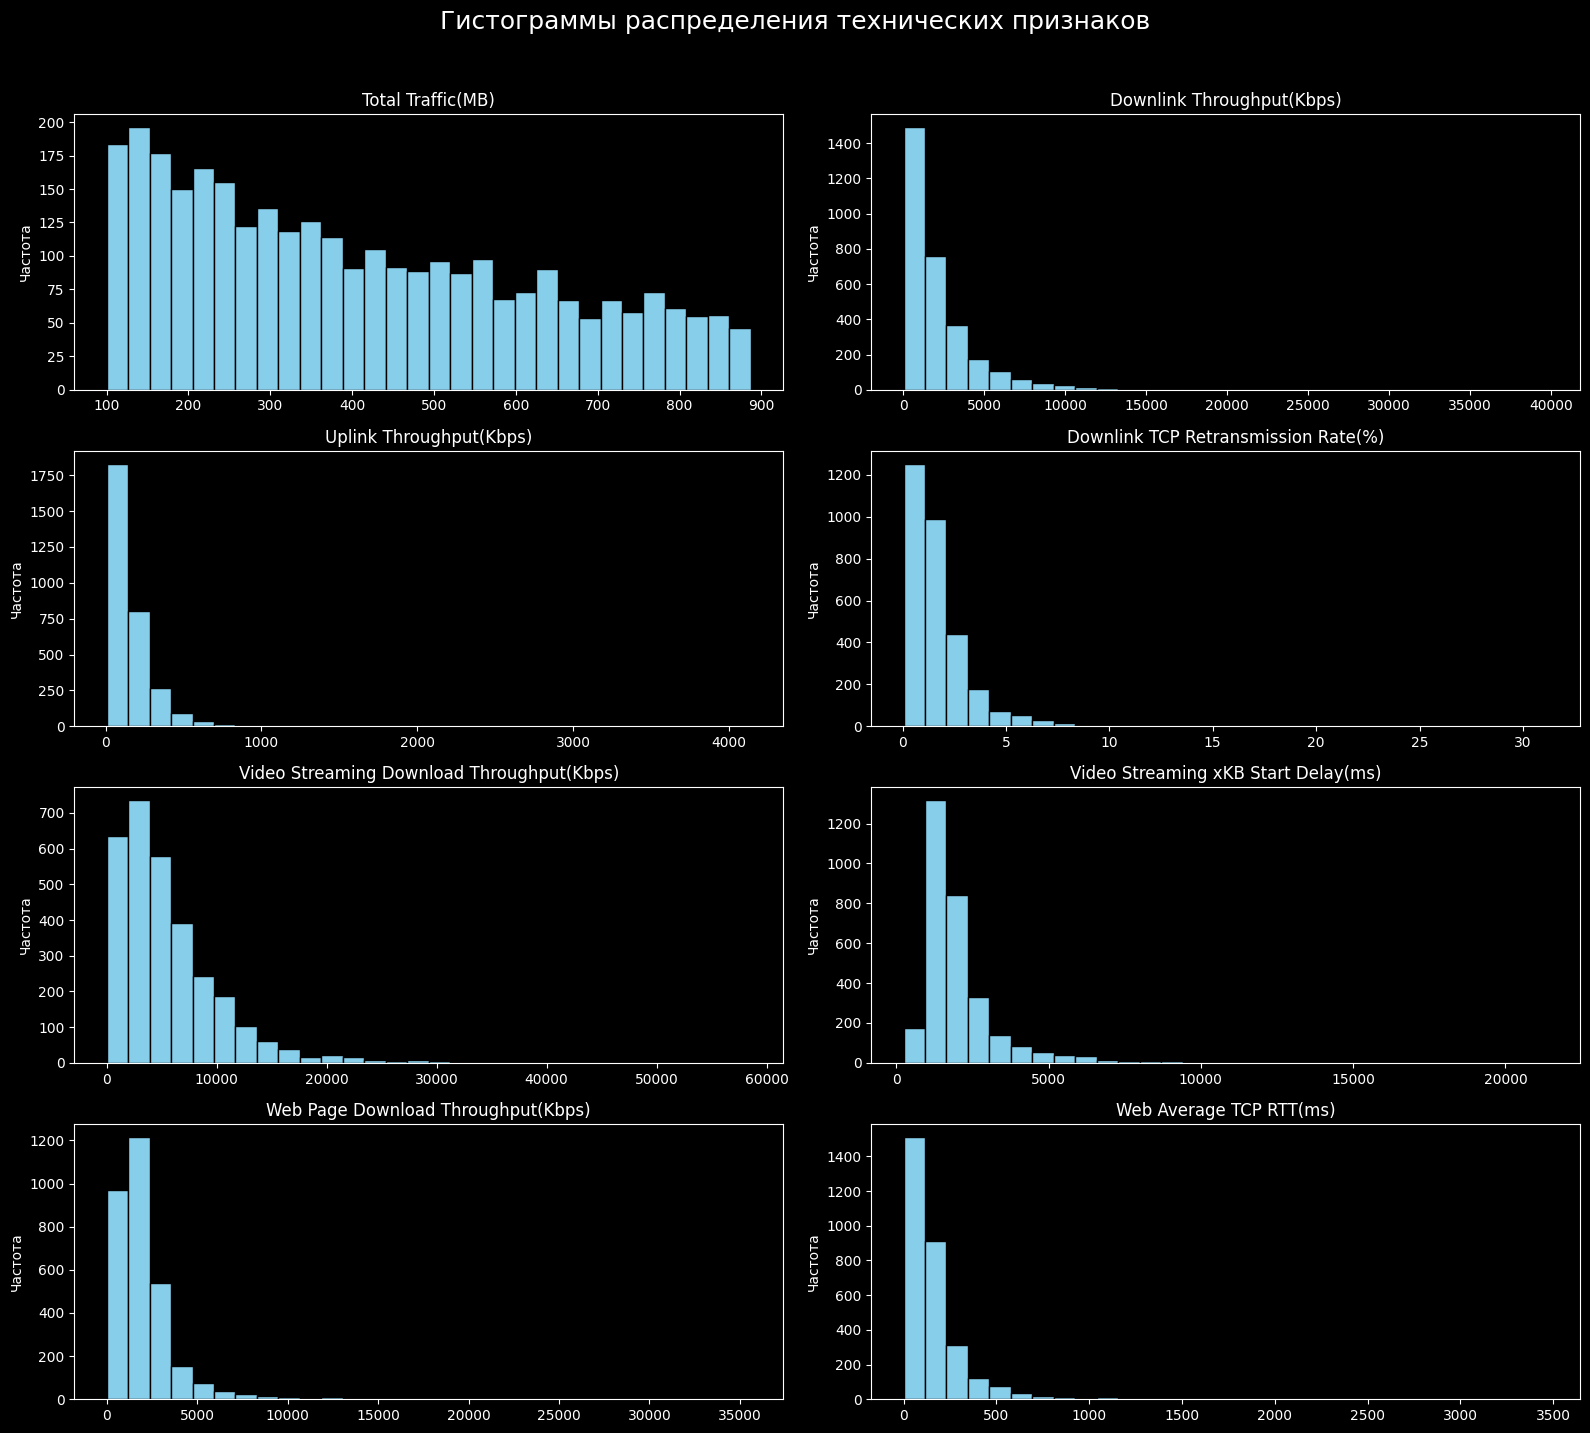

In [ ]:
tech_columns = [
    'Total Traffic(MB)', 'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
    'Downlink TCP Retransmission Rate(%)', 'Video Streaming Download Throughput(Kbps)',
    'Video Streaming xKB Start Delay(ms)', 'Web Page Download Throughput(Kbps)',
    'Web Average TCP RTT(ms)'
]

# Гистограммы на сетке 4x2
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(tech_columns):
    axes[i].hist(df[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Частота')

plt.suptitle('Гистограммы распределения технических признаков', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

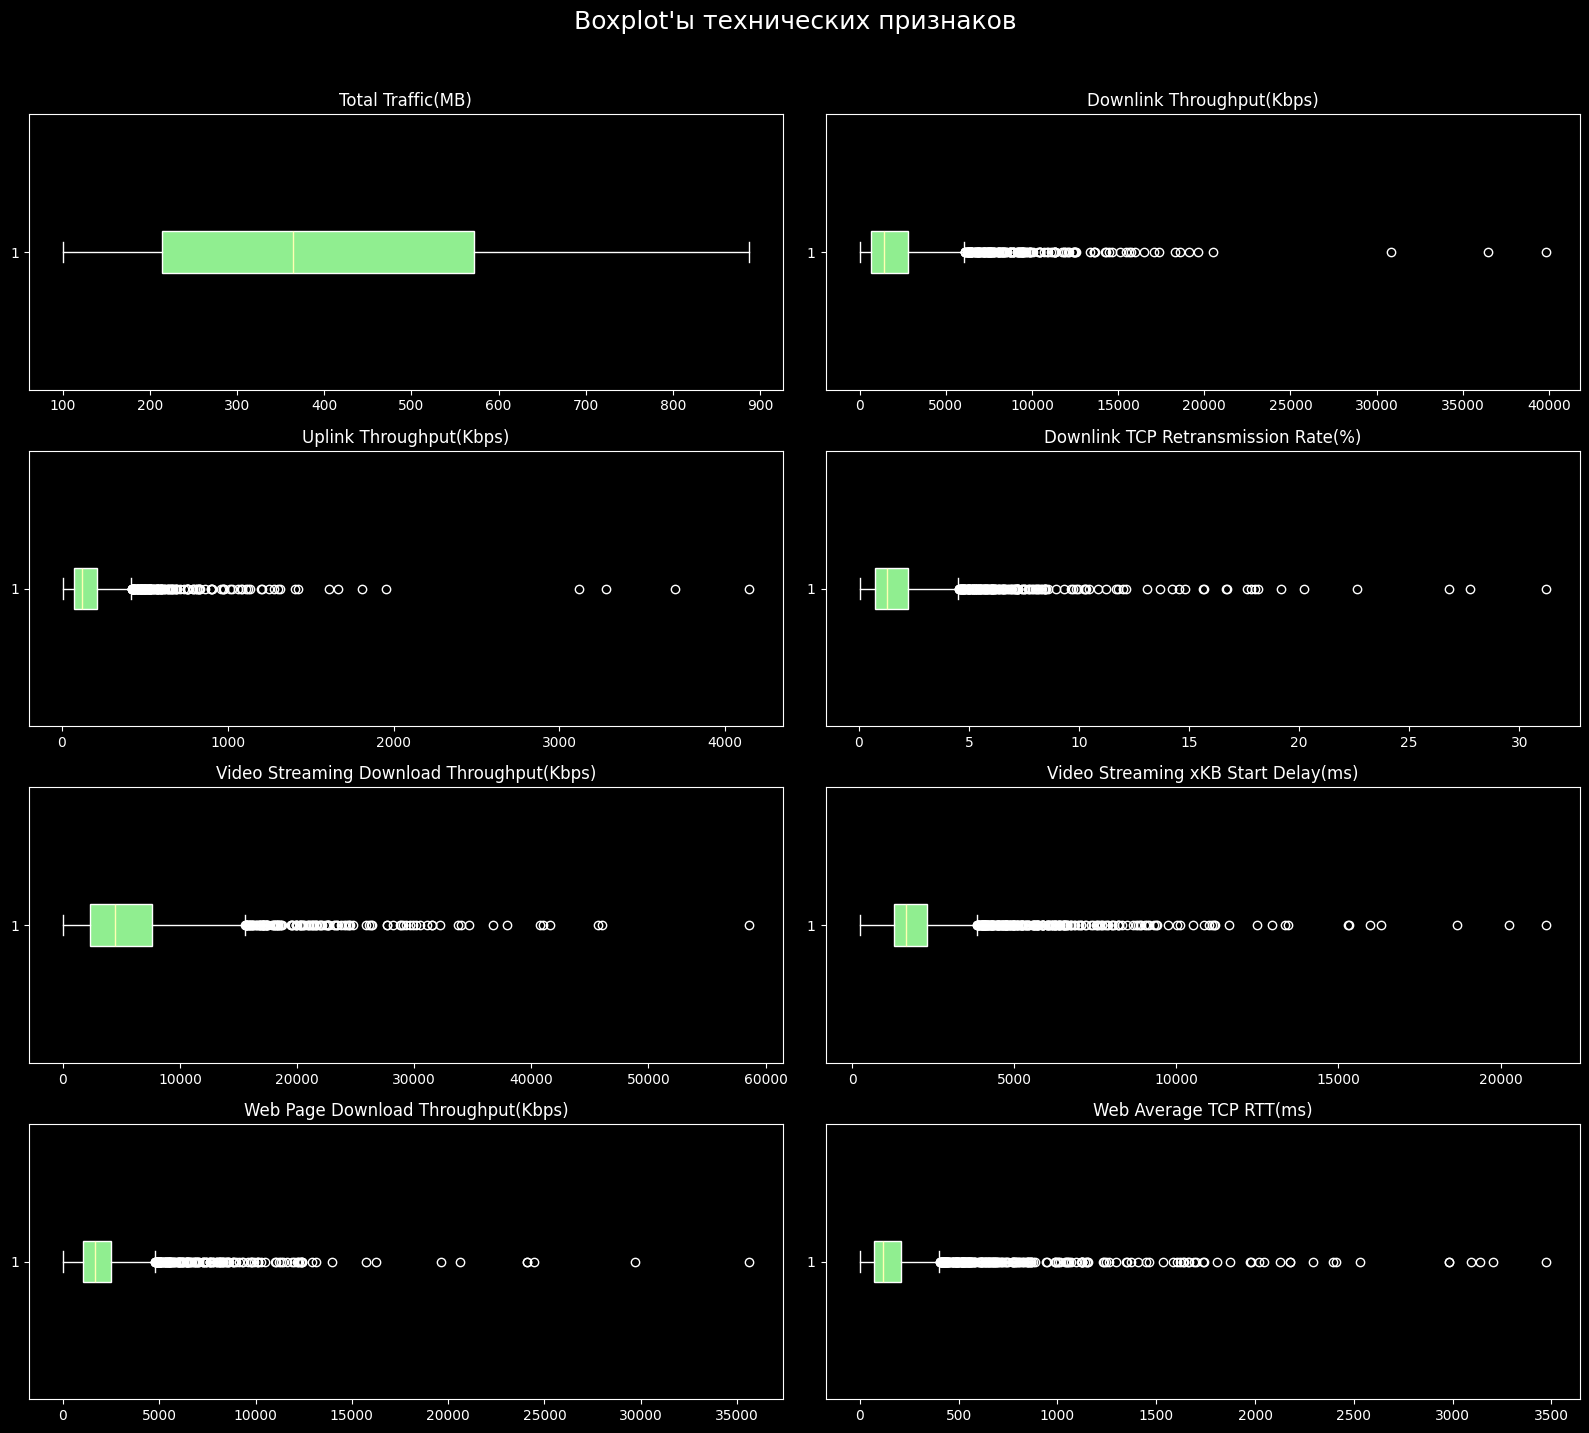

In [ ]:
# Boxplot'ы на сетке 4x2
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(tech_columns):
    axes[i].boxplot(df[col].dropna(), vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightgreen'))
    axes[i].set_title(col)

plt.suptitle('Boxplot\'ы технических признаков', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

#Результат проверки и предобработки:


*   Пропущенные значения обнаружены только в столбце Q2, что ожидаемо, поскольку этот вопрос задавался не всем пользователям.
*   Столбец Q1 изначально содержал строковые и некорректные значения, что было устранено: оставлены только числовые значения в диапазоне от 1 до 10.
*   Большинство технических метрик (скорости, задержки, пинг) имеют асимметричное распределение с выраженной правой скошенностью.
*   Метрика Total Traffic (MB) имеет более равномерное распределение, но также с легкой скошенностью вправо.
*  Выбросы присутствуют практически во всех технических признаках, особенно в задержках и скоростях. Это следует учитывать при дальнейшем анализе и при выборе статистических методов.
*  Для дальнейших шагов (например, проверки гипотез и построения моделей) будет разумно применить логарифмическое преобразование к сильно скошенным признакам — но только на этапе статистических тестов или моделирования, чтобы сохранить интерпретируемость на EDA-этапе
   



#EDA

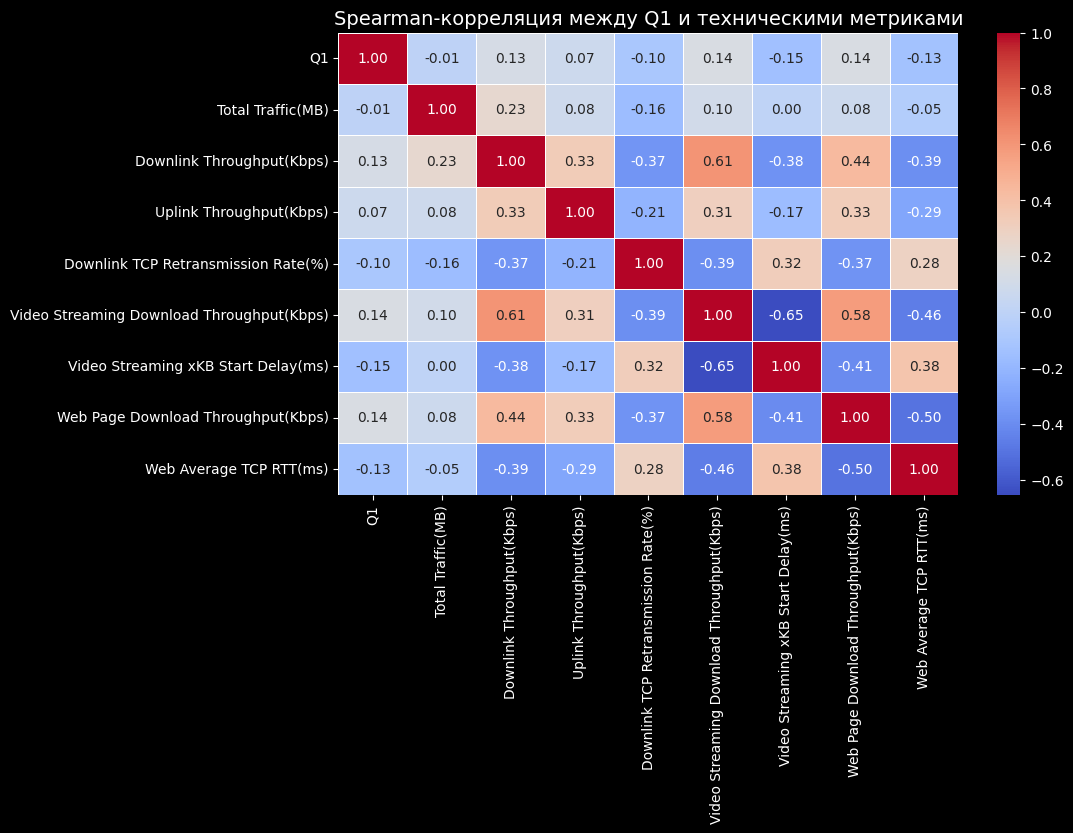

In [ ]:
# Список технических метрик
tech_columns = [
    'Total Traffic(MB)', 'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
    'Downlink TCP Retransmission Rate(%)', 'Video Streaming Download Throughput(Kbps)',
    'Video Streaming xKB Start Delay(ms)', 'Web Page Download Throughput(Kbps)',
    'Web Average TCP RTT(ms)'
]

# Строим матрицу корреляций с методом Спирмена. Используем Spearman, т.к. он не требует нормального распределения и устойчив к выбросам
corr_matrix = df[['Q1'] + tech_columns].corr(method='spearman')

# Визуализируем
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman-корреляция между Q1 и техническими метриками', fontsize=14)
plt.show()

Самую высокую негативную корреляцию с Q1 наблюдаем у признака Video Streaming xKB Start Delay(ms). С него и начнем.

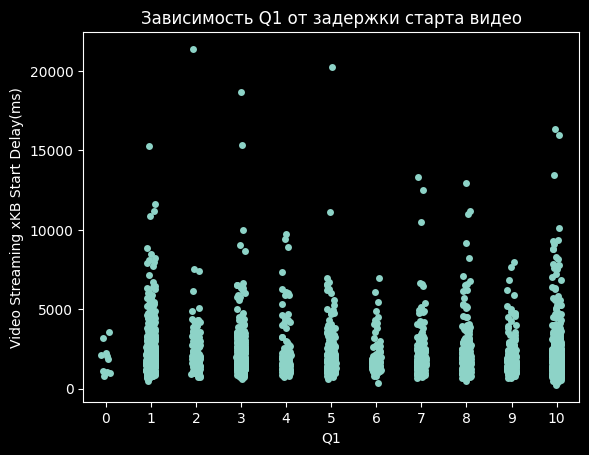

In [ ]:
# @title
sns.stripplot(x='Q1', y='Video Streaming xKB Start Delay(ms)', data=df, jitter=True)
plt.title('Зависимость Q1 от задержки старта видео')
plt.show()


График картину не проясняет. Посмотрим на меры центральной тенденции.

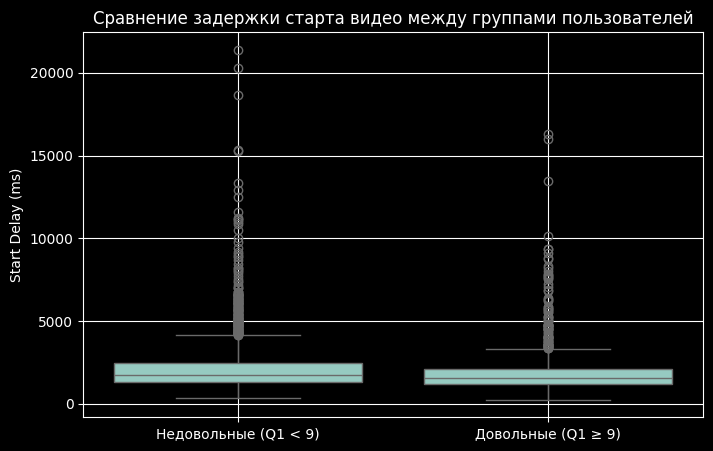

In [ ]:
# @title
# Создаём колонку-флаг: довольные (1) и недовольные (0)
df['Q1_group'] = df['Q1'].apply(lambda x: 1 if x >= 9 else 0)

plt.figure(figsize=(8, 5))
sns.boxplot(x='Q1_group', y='Video Streaming xKB Start Delay(ms)', data=df)
plt.xticks([0, 1], ['Недовольные (Q1 < 9)', 'Довольные (Q1 ≥ 9)'])
plt.title('Сравнение задержки старта видео между группами пользователей')
plt.xlabel('')
plt.ylabel('Start Delay (ms)')
plt.grid(True)
plt.show()

In [ ]:
# Среднее и медиана по группам
group_stats = df.groupby('Q1_group')['Video Streaming xKB Start Delay(ms)'].agg(['mean', 'median', 'count'])
print(group_stats)


                 mean  median  count
Q1_group                            
0         2216.721270  1724.5   1984
1         1918.149954  1552.0   1087


В процессе разведочного анализа было выявлено, что признак Video Streaming xKB Start Delay(ms) (задержка старта воспроизведения видео) имеет:

Сильно скошенное распределение с длинным правым хвостом и множеством выбросов;

Слабую отрицательную корреляцию с оценкой удовлетворённости Q1 (ρ ≈ –0.15 по Спирману);

Незначительно различимые распределения на stripplot’е, но:

Более выраженное различие при группировке по Q1 ≥ 9 и Q1 < 9:

Средняя задержка у недовольных ≈ 2217 мс, у довольных ≈ 1918 мс

Медиана отличается на ≈ 172 мс

Boxplot также показал смещение медиан, хотя диапазоны остаются перекрывающимися.

Таким образом, несмотря на то что визуальная и корреляционная связь не является сильной, мы всё же видим:

Систематическое смещение в значениях задержки между двумя группами,

Предпосылки к статистически значимому различию, особенно на больших выборках.

#1 гипотеза
— Нулевая гипотеза: Средняя задержка старта у недовольных меньше или равна задержке у довольных.

— Альтернативная гипотеза: Средняя задержка старта у недовольных выше, чем у довольных.

Так как предварительный анализ показал отрицательную корреляцию между оценкой Q1 и задержкой старта видео, а также средние значения задержки выше у недовольных пользователей, была выбрана односторонняя проверка гипотезы, направленная на подтверждение, что большее время задержки связано с более низкими оценками.

Для проверки статистической значимости различий между двумя группами пользователей — довольных (оценка Q1 ≥ 9) и недовольных (Q1 < 9) — по признаку задержки старта видео мы использовали односторонний Mann–Whitney U-тест.

1. Нормальность распределений отсутствует

Распределение задержки старта видео сильно скошено, содержит большое количество выбросов, что нарушает предпосылки параметрических тестов, таких как t-test.

2. Разный размер групп

Mann–Whitney U устойчив к несбалансированным группам, в отличие от некоторых других тестов, чувствительных к размеру выборки.

3. Тест не требует нормальности или гомогенности дисперсий

Это делает его особенно подходящим для анализа реальных, шумных данных, как в нашем случае.

4. Используется односторонняя альтернатива

На основании предварительного анализа (отрицательная корреляция, визуализация, средние/медианы), была сформулирована односторонняя гипотеза:

Пользователи, недовольные качеством связи, сталкиваются с большей задержкой старта видео.

5. Надёжность при наличии выбросов

В отличие от t-теста, Mann–Whitney менее чувствителен к экстремальным значениям, которые были выявлены в разведывательном анализе.

In [ ]:
from scipy.stats import mannwhitneyu

# Группы
group_bad = df[df['Q1_group'] == 0]['Video Streaming xKB Start Delay(ms)']
group_good = df[df['Q1_group'] == 1]['Video Streaming xKB Start Delay(ms)']

# Односторонний тест (проверяем, что у недовольных больше)
stat, p = mannwhitneyu(group_bad, group_good, alternative='greater')

print(f'U-статистика = {stat:.2f}')
print(f'p-value = {p:.4f}')


U-статистика = 1243574.00
p-value = 0.0000


После проведения Mann–Whitney U-теста мы получили статистически значимое различие между группами — недовольные пользователи сталкиваются с большей задержкой старта видео.

Однако сам тест:

— не показывает, насколько именно различаются значения в группах;

— не даёт доверительного интервала для этой разницы;


Применим бутстрап, чтобы:

1. Оценить численно разницу в средней задержке между группами;

2. Построить доверительный интервал для этой разницы;

3. Проверить устойчивость вывода — насколько часто при случайных перевыборках наблюдается эффект;

4. Визуализировать результат.

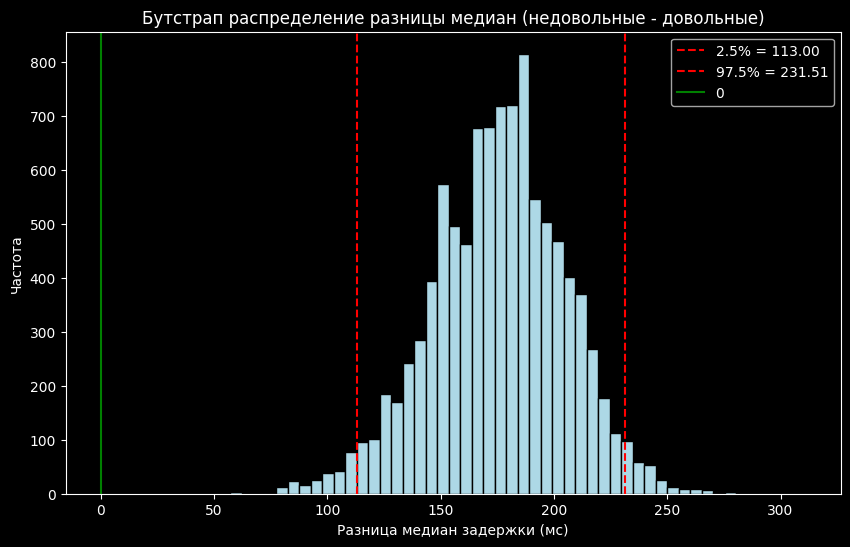

95% доверительный интервал разницы медиан: [113.00, 231.51] мс


In [ ]:
# Исходные группы
group_bad = df[df['Q1_group'] == 0]['Video Streaming xKB Start Delay(ms)'].values
group_good = df[df['Q1_group'] == 1]['Video Streaming xKB Start Delay(ms)'].values

# Параметры бутстрапа
n_iterations = 10000
boot_median_diffs = []

np.random.seed(42)  # для воспроизводимости

for _ in range(n_iterations):
    boot_bad = np.random.choice(group_bad, size=len(group_bad), replace=True)
    boot_good = np.random.choice(group_good, size=len(group_good), replace=True)
    boot_median_diffs.append(np.median(boot_bad) - np.median(boot_good))

# Доверительный интервал
ci_lower = np.percentile(boot_median_diffs, 2.5)
ci_upper = np.percentile(boot_median_diffs, 97.5)

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(boot_median_diffs, bins=50, color='lightblue', edgecolor='black')
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5% = {ci_lower:.2f}')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'97.5% = {ci_upper:.2f}')
plt.axvline(0, color='green', linestyle='-', label='0')
plt.title('Бутстрап распределение разницы медиан (недовольные - довольные)')
plt.xlabel('Разница медиан задержки (мс)')
plt.ylabel('Частота')
plt.legend()
plt.show()

print(f'95% доверительный интервал разницы медиан: [{ci_lower:.2f}, {ci_upper:.2f}] мс')


Нулевая гипотеза (что медианы равны) отвергается:

(0) вне доверительного интервала — значит, разница статистически значима.

Вывод по направлению эффекта:
Поскольку распределение целиком справа от нуля, мы уверенно можем сказать, что у недовольных пользователей видео запускается медленнее в среднем на 113–231 мс.

Бутстрап-распределение симметрично и гладкое, это признак того, что метод сработал хорошо.

Пик около 170 мс — это приблизительная медианная разница между группами.

#Вывод по первой гипотезе:
Мы исследовали влияние технического параметра "задержка старта видео" на пользовательскую оценку качества связи (Q1). Предварительный разведочный анализ показал наличие визуального и числового отличия между группами пользователей, оценивших качество связи высоко (Q1 ≥ 9) и низко (Q1 < 9). Несмотря на низкую корреляцию, мы предположили наличие статистически значимого различия в медианных задержках между группами. Для проверки гипотезы мы использовали непараметрический тест Манна–Уитни, поскольку данные имеют значительное количество выбросов, отличаются по размеру выборок, а также демонстрируют смещённое распределение. Результат теста показал статистически значимое различие (p-value < 0.0001), в пользу того, что у недовольных пользователей задержка выше. Для дополнительного подтверждения результата мы провели бутстрап-анализ разницы медиан между группами, что позволило получить 95% доверительный интервал: [113.00 мс, 231.51 мс]. Интервал полностью лежит выше нуля, что подтверждает устойчивость эффекта. Таким образом, можно сделать обоснованный вывод: увеличение времени старта воспроизведения видео оказывает негативное влияние на восприятие качества связи со стороны пользователей. Результаты анализа помогут «Мегафону» приоритизировать технические улучшения в области потокового видео как одного из факторов удовлетворённости.



In [ ]:
# Фильтруем недовольных пользователей
df_bad = df[df['Q1_group'] == 0]

# Выбираем только Q2 бинарные столбцы
q2_columns = ['0', '1',	'2',	'3',	'4',	'5',	'6',	'7']

# Считаем сумму (частоту) по каждому признаку
q2_counts = df_bad[q2_columns].sum().sort_values(ascending=False)

print(q2_counts)


3    706.0
1    648.0
4    626.0
5    222.0
2    184.0
7     86.0
6     13.0
0      5.0
dtype: float64


На основе анализа частоты упоминаний причин неудовлетворённости (вопрос Q2), мы выделили три наиболее часто встречающиеся жалобы:

1. плохое качество связи в зданиях, ТЦ и т.п. (причина №3);

2. долгое ожидание гудков при звонке (причина №1);

3. медленный мобильный интернет (причина №4).

Причина №3 не может быть количественно исследована в рамках текущего набора данных, так как у нас отсутствует информация о местоположении пользователей или о характеристиках среды (например, нахождение внутри зданий или наличие ослабленного сигнала). Без геопространственных или контекстных данных невозможно связать эту жалобу с техническими метриками напрямую.

Причина №1 относится к голосовой связи и времени установления соединения при звонках. Однако в данных отсутствуют специализированные метрики, отражающие характеристики голосовой сети, сигнального канала или call setup delay. Метрика Web Page Download Throughput, на первый взгляд схожая по сути (восприятие скорости), относится к интернет-соединению и не может быть интерпретирована как отражающая проблемы с голосовой связью. В связи с этим эта причина также исключается из анализа.

Таким образом, мы сосредотачиваем внимание на причине №4 — "медленный мобильный интернет", поскольку она входит в топ-3 жалоб пользователей и имеет очевидную интерпретируемую связь с техническими метриками.

#2 и 3 гипотезы

***Гипотеза 2 (по видео)***:

— Нулевая гипотеза (H₀): распределения Video Streaming Download Throughput не отличаются между довольными и недовольными пользователями.

— Альтернативная гипотеза (H₁): у недовольных пользователей Video Streaming Download Throughput статистически значимо ниже, чем у довольных.



***Гипотеза 3 (по web)***:

— Нулевая гипотеза (H₀): распределения Web Page Download Throughput не отличаются между довольными и недовольными пользователями.

— Альтернативная гипотеза (H₁): у недовольных пользователей Web Page Download Throughput статистически значимо ниже, чем у довольных.


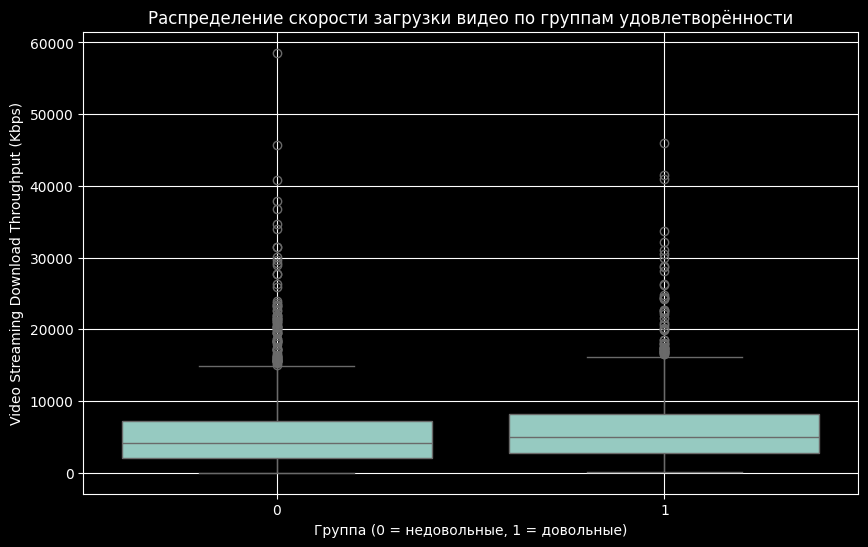

In [ ]:
# Разделим группы
df['Q1_group'] = (df['Q1'] >= 9).astype(int)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Q1_group', y='Video Streaming Download Throughput(Kbps)')
plt.title('Распределение скорости загрузки видео по группам удовлетворённости')
plt.xlabel('Группа (0 = недовольные, 1 = довольные)')
plt.ylabel('Video Streaming Download Throughput (Kbps)')
plt.grid(True)
plt.show()

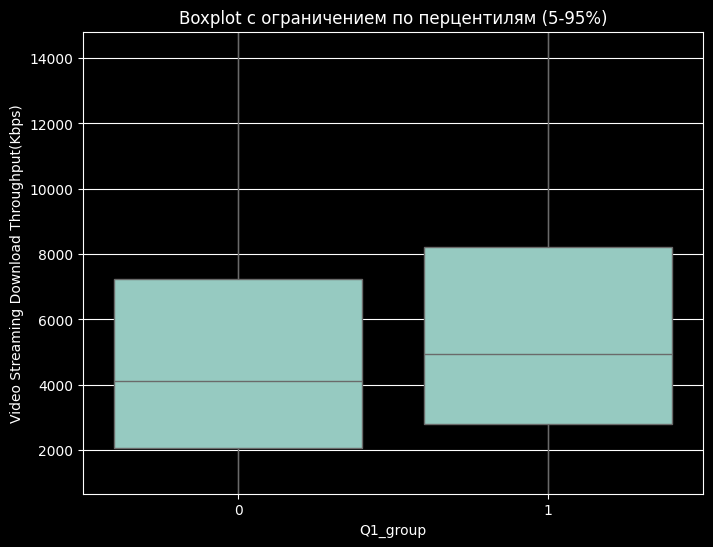

In [ ]:
# Обрезаем по 1-99 процентилям
q1 = df['Video Streaming Download Throughput(Kbps)'].quantile(0.05)
q99 = df['Video Streaming Download Throughput(Kbps)'].quantile(0.95)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Q1_group', y='Video Streaming Download Throughput(Kbps)', data=df)
plt.ylim(q1, q99)  # ограничиваем ось Y
plt.title("Boxplot с ограничением по перцентилям (5-95%)")
plt.grid(True)
plt.show()

Видим явное различие в распределении между группами довольных и недовольных пользователей.Недовольные пользователи имели более низкие значения метрики.

In [ ]:
# Данные
group_bad = df[df['Q1_group'] == 0]['Video Streaming Download Throughput(Kbps)']
group_good = df[df['Q1_group'] == 1]['Video Streaming Download Throughput(Kbps)']

# Односторонний тест (альтернатива: группа плохих < группа хороших)
stat, p = mannwhitneyu(group_bad, group_good, alternative='less')

print(f'U-статистика: {stat:.2f}')
print(f'p-value: {p:.4f}')


U-статистика: 938520.00
p-value: 0.0000


Результаты теста показали статистически значимое различие (p-value < 0.0001) в пользу того, что у недовольных пользователей скорость загрузки видео ниже.

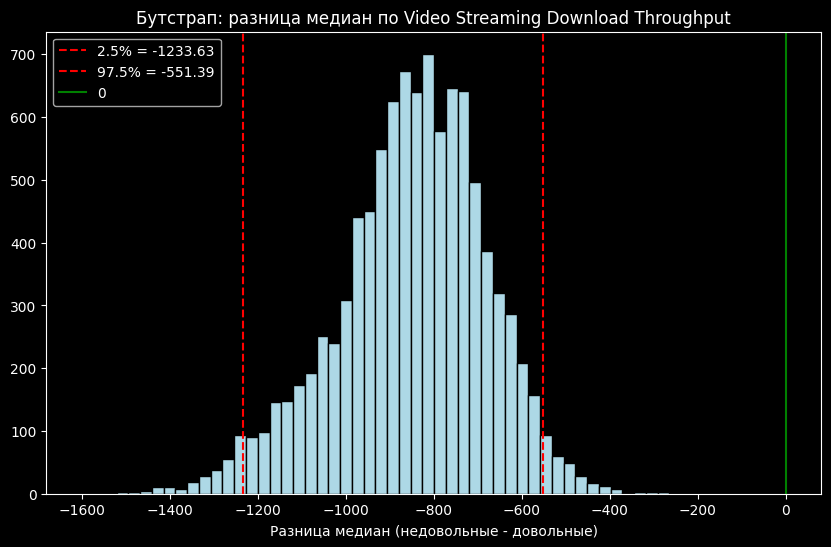

95% доверительный интервал разницы медиан: [-1233.63, -551.39] Kbps


In [ ]:
boot_diffs = []
np.random.seed(42)

for _ in range(10000):
    boot_bad = np.random.choice(group_bad, size=len(group_bad), replace=True)
    boot_good = np.random.choice(group_good, size=len(group_good), replace=True)
    boot_diffs.append(np.median(boot_bad) - np.median(boot_good))

# Интервал
ci_low = np.percentile(boot_diffs, 2.5)
ci_high = np.percentile(boot_diffs, 97.5)

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(boot_diffs, bins=50, color='lightblue', edgecolor='black')
plt.axvline(ci_low, color='red', linestyle='--', label=f'2.5% = {ci_low:.2f}')
plt.axvline(ci_high, color='red', linestyle='--', label=f'97.5% = {ci_high:.2f}')
plt.axvline(0, color='green', linestyle='-', label='0')
plt.title('Бутстрап: разница медиан по Video Streaming Download Throughput')
plt.xlabel('Разница медиан (недовольные - довольные)')
plt.legend()
plt.show()

print(f'95% доверительный интервал разницы медиан: [{ci_low:.2f}, {ci_high:.2f}] Kbps')


Для дополнительной проверки был применён бутстрап-анализ разницы медиан, который также показал устойчивую отрицательную разницу между группами. 95% доверительный интервал разницы медиан: [-1233.63, -551.39] Kbps, полностью исключает ноль, что подтверждает значимость наблюдаемого эффекта.

#Вывод по второй гипотезе
Низкая скорость загрузки видео негативно влияет на восприятие качества связи со стороны пользователей, и этот параметр должен быть приоритетной целью для технических улучшений.

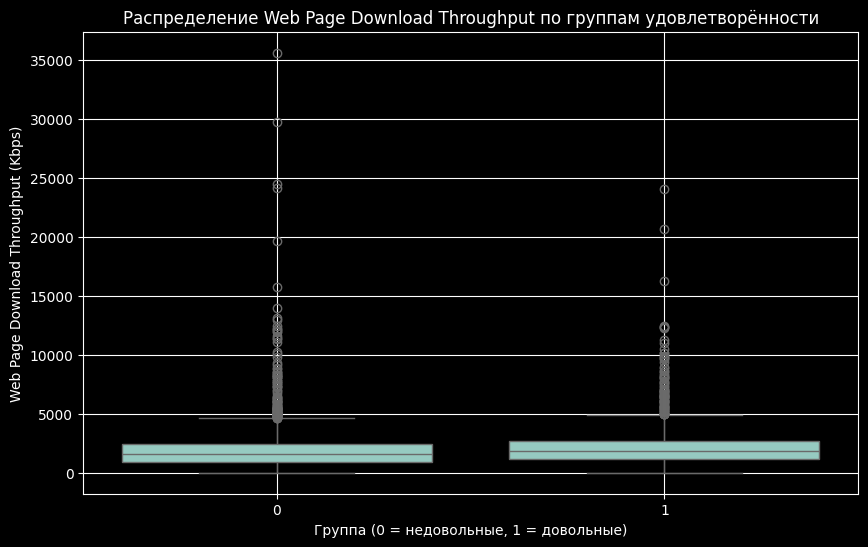

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Q1_group', y='Web Page Download Throughput(Kbps)')
plt.title('Распределение Web Page Download Throughput по группам удовлетворённости')
plt.xlabel('Группа (0 = недовольные, 1 = довольные)')
plt.ylabel('Web Page Download Throughput (Kbps)')
plt.grid(True)
plt.show()


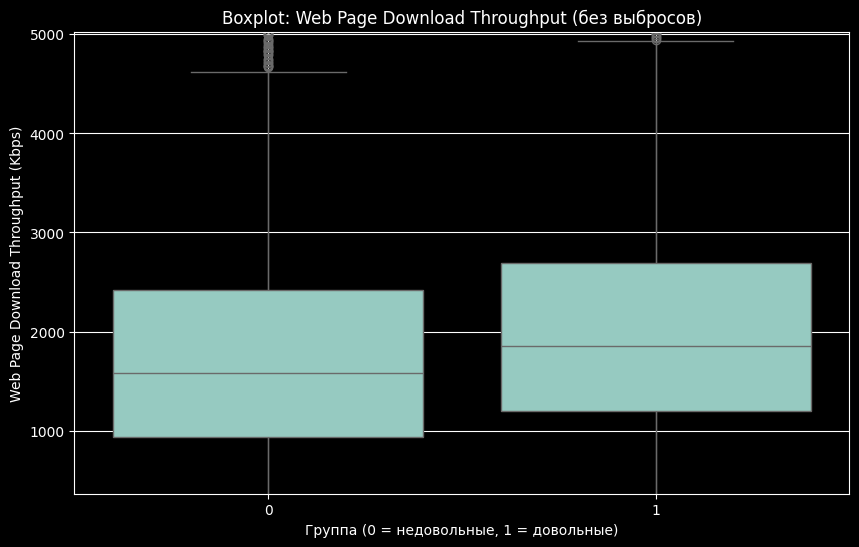

In [ ]:
q_low = df['Web Page Download Throughput(Kbps)'].quantile(0.05)
q_high = df['Web Page Download Throughput(Kbps)'].quantile(0.95)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Q1_group', y='Web Page Download Throughput(Kbps)')
plt.ylim(q_low, q_high)
plt.title('Boxplot: Web Page Download Throughput (без выбросов)')
plt.xlabel('Группа (0 = недовольные, 1 = довольные)')
plt.ylabel('Web Page Download Throughput (Kbps)')
plt.grid(True)
plt.show()


In [ ]:
bad = df[df['Q1_group'] == 0]['Web Page Download Throughput(Kbps)']
good = df[df['Q1_group'] == 1]['Web Page Download Throughput(Kbps)']

stat, p = mannwhitneyu(bad, good, alternative='less')
print(f'U-статистика: {stat:.2f}')
print(f'p-value: {p:.4f}')


U-статистика: 926878.00
p-value: 0.0000


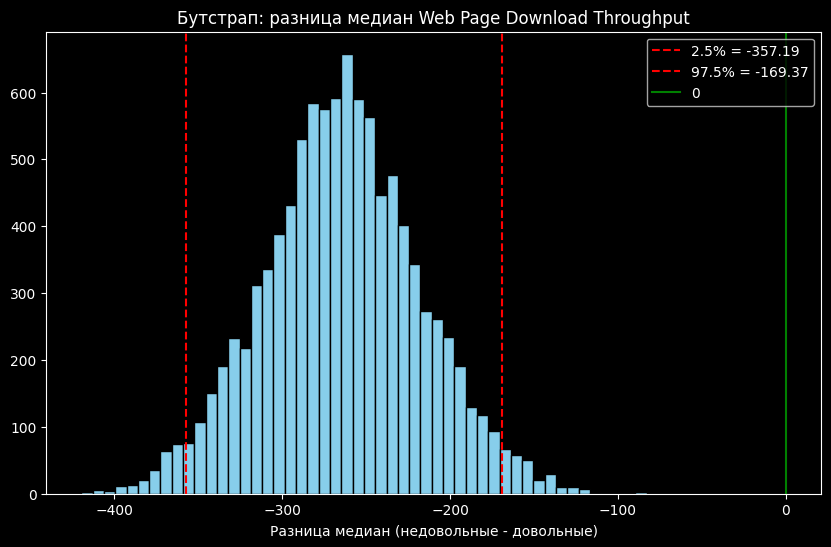

95% доверительный интервал: [-357.19, -169.37]


In [ ]:
boot_diffs = []
np.random.seed(42)

for _ in range(10000):
    sample_bad = np.random.choice(bad, size=len(bad), replace=True)
    sample_good = np.random.choice(good, size=len(good), replace=True)
    boot_diffs.append(np.median(sample_bad) - np.median(sample_good))

ci_low = np.percentile(boot_diffs, 2.5)
ci_high = np.percentile(boot_diffs, 97.5)

plt.figure(figsize=(10, 6))
plt.hist(boot_diffs, bins=50, color='skyblue', edgecolor='black')
plt.axvline(ci_low, color='red', linestyle='--', label=f'2.5% = {ci_low:.2f}')
plt.axvline(ci_high, color='red', linestyle='--', label=f'97.5% = {ci_high:.2f}')
plt.axvline(0, color='green', linestyle='-', label='0')
plt.title('Бутстрап: разница медиан Web Page Download Throughput')
plt.xlabel('Разница медиан (недовольные - довольные)')
plt.legend()
plt.show()

print(f'95% доверительный интервал: [{ci_low:.2f}, {ci_high:.2f}]')


#Вывод по третьей гипотезе:
У недовольных пользователей скорость загрузки веб-страниц статистически значимо ниже. Наблюдаемая разница медиан составляет примерно -270 Kbps, что указывает на значимое снижение скорости у недовольных пользователей. Этот параметр также должен быть учтён в приоритизации технических улучшений.

#SHAP-анализ

In [ ]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
import shap


# 1. Определяем целевую и признаки
target = 'Q1_group'
tech_columns = [
    'Total Traffic(MB)', 'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)',
    'Downlink TCP Retransmission Rate(%)', 'Video Streaming Download Throughput(Kbps)',
    'Video Streaming xKB Start Delay(ms)', 'Web Page Download Throughput(Kbps)',
    'Web Average TCP RTT(ms)'
]
q2_columns = [str(i) for i in range(8)]  # если именно так названы бинарные столбцы

feature_columns = tech_columns + q2_columns

X = df[feature_columns]
y = df[target]

# 2. Разбиваем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Обучаем CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# 4. Оцениваем качество
print("Accuracy на тесте:", model.score(X_test, y_test))

# 5. SHAP‑анализ
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 6. Визуализация важности признаков
plt.figure()
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    max_display=20,
    show=False  # отключаем автоматический показ
)

# Подпишем X-ось вручную
plt.gcf().set_size_inches(10, 6)  # Устанавливаем размер холста
plt.xlabel("Среднее значение SHAP (влияние на выход модели)", fontsize=12, labelpad=15)
plt.tight_layout(pad=2.0)  # Увеличиваем отступы для подписей

plt.show()


ModuleNotFoundError: No module named 'catboost'

#Вывод по SHAP
1, 3 и 6 причины мы исследовать не сможем. 0 - это мусор в данных. 4 уже исследовали.

Других значимых признаков выявить не удалось.

#Заключение

В ходе анализа были изучены факторы, влияющие на пользовательскую оценку качества связи (Q1), с целью выявления приоритетных направлений для технических улучшений.

1. Предобработка и группировка:
Пользователи были разделены на две группы по значению Q1:

Недовольные (Q1 < 9) /
Довольные (Q1 ≥ 9)

Также были выделены бинарные признаки Q2, отражающие причины низкой оценки.

2. Первичный разведочный анализ (EDA):
Корреляционный анализ показал слабую линейную связь между техническими метриками и Q1. Однако визуализация распределений и статистические проверки выявили наличие значимых различий между группами по ряду метрик.

3. Проверка гипотез:
Проверено влияние трёх ключевых технических параметров:

— Video Streaming Start Delay (задержка старта видео):
Гипотеза подтвердилась — у недовольных пользователей задержка медианно выше.
Подтверждено тестом Манна–Уитни и бутстрапом разницы медиан.

→ Video Streaming Download Throughput (скорость загрузки видео):
Гипотеза подтвердилась — скорость у недовольных статистически ниже.
Подтверждено обоими тестами.

— Web Page Download Throughput (скорость загрузки веб-страниц):
Также показала значимое снижение у недовольных пользователей.

4. Анализ бинарных жалоб Q2:
Наиболее частые причины низкой оценки — медленная загрузка видео, обрывы звонков и плохое качество связи в помещениях.
Не все причины можно количественно исследовать из-за отсутствия соответствующих метрик.

5. SHAP-анализ через модель CatBoost:
Обученная модель с точностью ~80% показала, что наиболее значимыми признаками являются именно жалобы из Q2.
Наиболее важные технические метрики уже были проверены гипотезами.
SHAP-анализ не выявил новых кандидатов для исследования.

Пользовательская оценка Q1 действительно чувствительна к ряду технических параметров, особенно связанных с видео- и веб-загрузкой. Эти метрики следует рассматривать как приоритетные для мониторинга и оптимизации. Использование модели позволило подтвердить значимость ранее выявленных признаков и исключить менее важные. Полученные результаты дают обоснование для технических решений, направленных на повышение удовлетворенности пользователей.